# Decoder-Only Image-to-Text: Demo

This notebook demonstrates the **pretrained model** for handwriting recognition.

## Training Results (from `train_sota.py`)
- **Model**: Small (9.8M params)
- **Train Samples**: 400
- **Best Val CER**: 86.59%
- **Test CER**: 80.49%
- **Checkpoint**: `outputs/sota_small/best_model.pt`

## Architecture
```
Line Image ÃƒÆ’Ã‚Â¢ÃƒÂ¢Ã¢â€šÂ¬Ã‚Â ÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢ ConvEncoder ÃƒÆ’Ã‚Â¢ÃƒÂ¢Ã¢â€šÂ¬Ã‚Â ÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢ Visual Tokens ÃƒÆ’Ã‚Â¢ÃƒÂ¢Ã¢â€šÂ¬Ã‚Â ÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢ [Visual | Text] ÃƒÆ’Ã‚Â¢ÃƒÂ¢Ã¢â€šÂ¬Ã‚Â ÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢ Self-Attention ÃƒÆ’Ã‚Â¢ÃƒÂ¢Ã¢â€šÂ¬Ã‚Â ÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢ Next Token
```


In [30]:
# Imports
import sys
import json
import importlib
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Add project root to path
sys.path.insert(0, str(Path('.').resolve()))

# Force reload modules
import data.line_dataset
importlib.reload(data.line_dataset)

from model import DecoderOnlyImageToText, DecoderOnlyConfig
from data.line_dataset import create_line_dataloaders

# Device setup
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if device.type == 'cuda':
    print(f"GPU: {torch.cuda.get_device_name(0)}")


Using device: cuda
GPU: NVIDIA GeForce RTX 5090


## 1. Load Dataset


In [31]:
# =============================================================================
# Load Dataset
# =============================================================================

DATA_DIR = "data/line_text_dataset"
CHECKPOINT_PATH = "outputs/sota_full/best_model.pt"
RESULTS_PATH = "outputs/sota_full/results.json"

# Load data
train_loader, val_loader, test_loader = create_line_dataloaders(
    data_dir=DATA_DIR,
    batch_size=1,  # Small batch for demo
    image_height=64,
    image_width=256,
    max_text_len=256,
    augment_train=False,
)

# Load vocabulary
with open(Path(DATA_DIR) / 'vocabulary.json', 'r') as f:
    vocab = json.load(f)

vocab_size = len(vocab)
idx_to_char = {v: k for k, v in vocab.items()}

print(f"Test samples: {len(test_loader.dataset)}")
print(f"Vocabulary size: {vocab_size}")


Test samples: 1287
Vocabulary size: 86


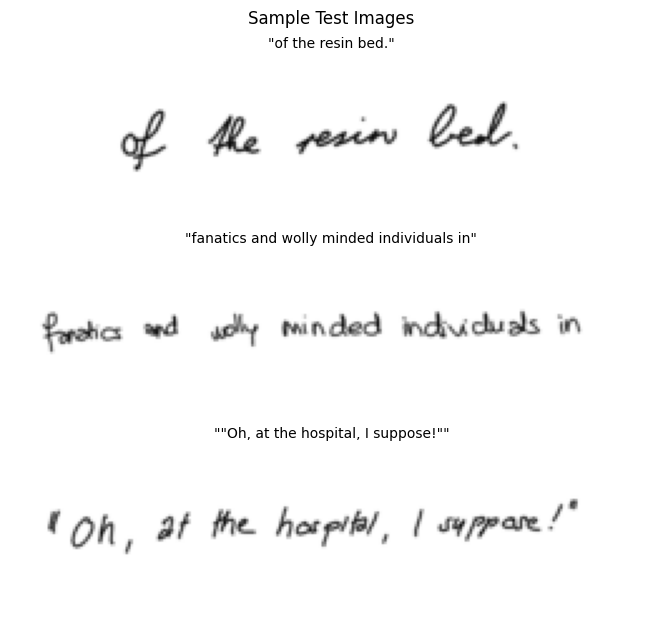

In [32]:
# Visualize sample data - get multiple samples
test_iter = iter(test_loader)
samples = [next(test_iter) for _ in range(3)]

fig, axes = plt.subplots(3, 1, figsize=(12, 6))
for i, batch in enumerate(samples):
    img = batch['images'][0, 0].numpy()
    text = batch['texts'][0]
    axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[i].set_title(f'"{text}"', fontsize=10)
    axes[i].axis('off')

plt.tight_layout()
plt.suptitle('Sample Test Images', y=1.02)
plt.show()


In [33]:
# Load training results
with open(RESULTS_PATH) as f:
    results = json.load(f)

print("Training Results:")
print(f"  Model: {results['config']['model_size']}")
print(f"  Parameters: {results['config']['num_params']:,}")
print(f"  Best Val CER: {results['best_cer']*100:.2f}%")
print(f"  Test CER: {results['test_metrics']['cer']*100:.2f}%")
print(f"  Test WER: {results['test_metrics']['wer']*100:.2f}%")


Training Results:
  Model: small
  Parameters: 9,871,414
  Best Val CER: 33.63%
  Test CER: 38.01%
  Test WER: 38.00%


## 2. Load Pretrained Model & Training Results


In [34]:
# Load pretrained model
checkpoint = torch.load(CHECKPOINT_PATH, map_location=device)

# Create config matching training
config = DecoderOnlyConfig(
    vocab_size=vocab_size,
    hidden_dim=256,
    num_layers=6,
    num_heads=8,
    ffn_dim=1024,
    max_seq_len=256,
    dropout=0.1,
    encoder_base_channels=32,
    encoder_num_stages=4,
    max_visual_tokens=256,
)

model = DecoderOnlyImageToText(config).to(device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print(f"Loaded model from epoch {checkpoint.get('epoch', 'N/A')}")
print(f"Parameters: {sum(p.numel() for p in model.parameters()):,}")

# Helper functions
def levenshtein_distance(s1, s2):
    if len(s1) < len(s2):
        return levenshtein_distance(s2, s1)
    if len(s2) == 0:
        return len(s1)
    prev = range(len(s2) + 1)
    for i, c1 in enumerate(s1):
        curr = [i + 1]
        for j, c2 in enumerate(s2):
            curr.append(min(prev[j+1]+1, curr[j]+1, prev[j]+(c1!=c2)))
        prev = curr
    return prev[-1]

def compute_cer(pred, target):
    if len(target) == 0:
        return 0.0 if len(pred) == 0 else 1.0
    return levenshtein_distance(pred, target) / len(target)

def decode_tokens(token_ids, idx_to_char, eos_id=2, bos_id=1, pad_id=0):
    chars = []
    for idx in token_ids:
        if idx == eos_id:
            break
        if idx not in [bos_id, pad_id]:
            chars.append(idx_to_char.get(idx, idx_to_char.get(str(idx), '?')))
    return ''.join(chars)


Loaded model from epoch 26
Parameters: 9,871,414


In [35]:
# Quick model test - generate from one image
test_batch = next(iter(test_loader))
test_img = test_batch['images'][:1].to(device)
target_text = test_batch['texts'][0]

with torch.no_grad():
    gen_ids = model.generate(test_img, max_length=64, temperature=0.0)

pred_text = decode_tokens(gen_ids[0].cpu().tolist(), idx_to_char)
cer = compute_cer(pred_text, target_text)

print(f"Target:    {target_text}")
print(f"Predicted: {pred_text}")
print(f"CER: {cer*100:.1f}%")
print("\nÃƒÆ’Ã‚Â¢Ãƒâ€¦Ã¢â‚¬Å“ÃƒÂ¢Ã¢â€šÂ¬Ã…â€œ Model loaded and working!")


Target:    of the resin bed.
Predicted: of the resin bed.
CER: 0.0%

ÃƒÆ’Ã‚Â¢Ãƒâ€¦Ã¢â‚¬Å“ÃƒÂ¢Ã¢â€šÂ¬Ã…â€œ Model loaded and working!


## 3. Training Curves (from saved results)


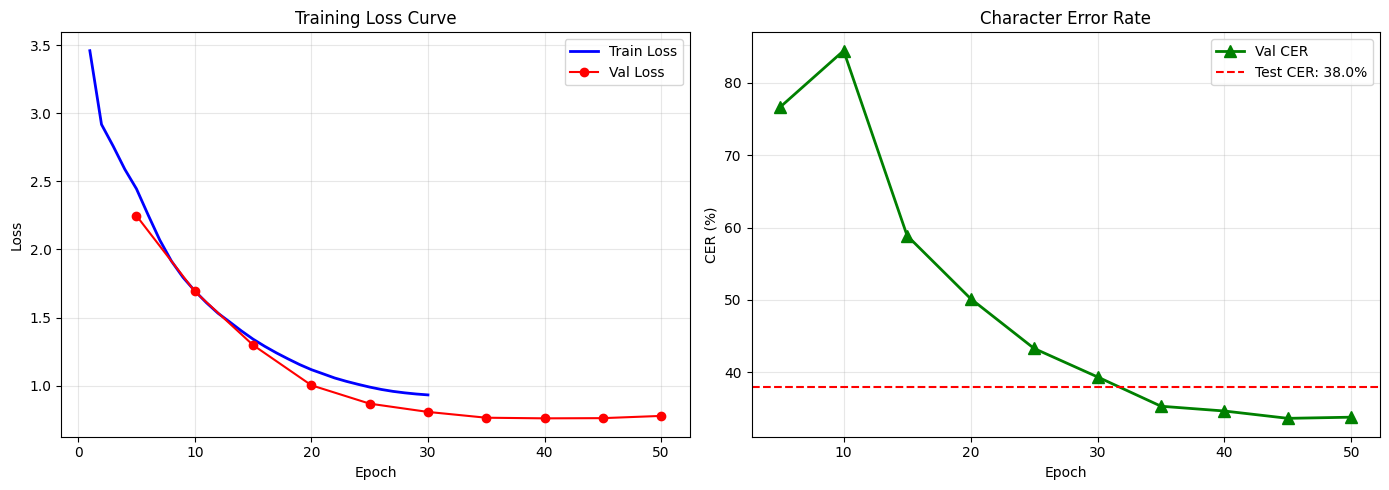

In [36]:
# Plot training curves from saved results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curve
epochs = range(1, len(results['train_losses']) + 1)
axes[0].plot(epochs, results['train_losses'], 'b-', label='Train Loss', linewidth=2)
val_epochs = [5*i for i in range(1, len(results['val_metrics'])+1)]
val_losses = [m['loss'] for m in results['val_metrics']]
axes[0].plot(val_epochs, val_losses, 'ro-', label='Val Loss', markersize=6)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss Curve')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# CER curve
val_cers = [m['cer']*100 for m in results['val_metrics']]
axes[1].plot(val_epochs, val_cers, 'g^-', label='Val CER', markersize=8, linewidth=2)
axes[1].axhline(y=results['test_metrics']['cer']*100, color='r', linestyle='--', 
                label=f"Test CER: {results['test_metrics']['cer']*100:.1f}%")
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('CER (%)')
axes[1].set_title('Character Error Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


In [37]:
# Training was done via train_sota.py
# To retrain: python train_sota.py --model_size small --epochs 50
print("Model was trained using train_sota.py")
print(f"Checkpoint: {CHECKPOINT_PATH}")

Model was trained using train_sota.py
Checkpoint: outputs/sota_full/best_model.pt


## 4. Final Loss Curves


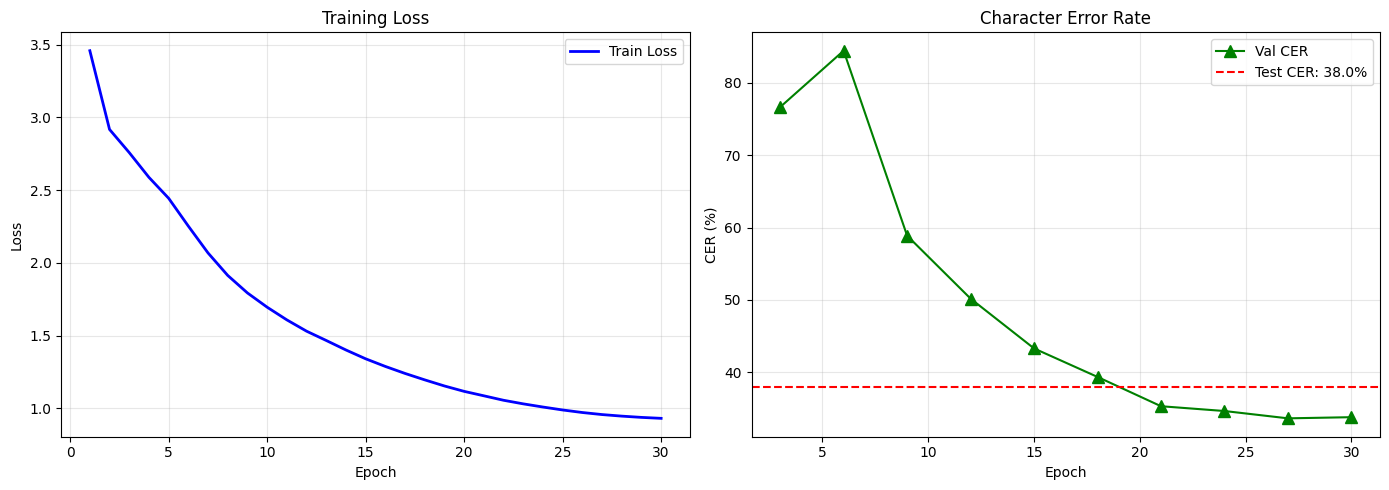

Best Val CER: 33.63%
Test CER: 38.01%


In [38]:
# Final visualization from saved results
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot training loss
epochs = range(1, len(results['train_losses']) + 1)
axes[0].plot(epochs, results['train_losses'], 'b-', label='Train Loss', linewidth=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot CER
val_epochs = [3*(i+1) for i in range(len(results['val_metrics']))]
val_cers = [m['cer']*100 for m in results['val_metrics']]
axes[1].plot(val_epochs, val_cers, 'g^-', label='Val CER', markersize=8)
axes[1].axhline(y=results['test_metrics']['cer']*100, color='r', linestyle='--', 
                label=f"Test CER: {results['test_metrics']['cer']*100:.1f}%")
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('CER (%)')
axes[1].set_title('Character Error Rate')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Best Val CER: {results['best_cer']*100:.2f}%")
print(f"Test CER: {results['test_metrics']['cer']*100:.2f}%")

## 5. Test Generation


Generating predictions...


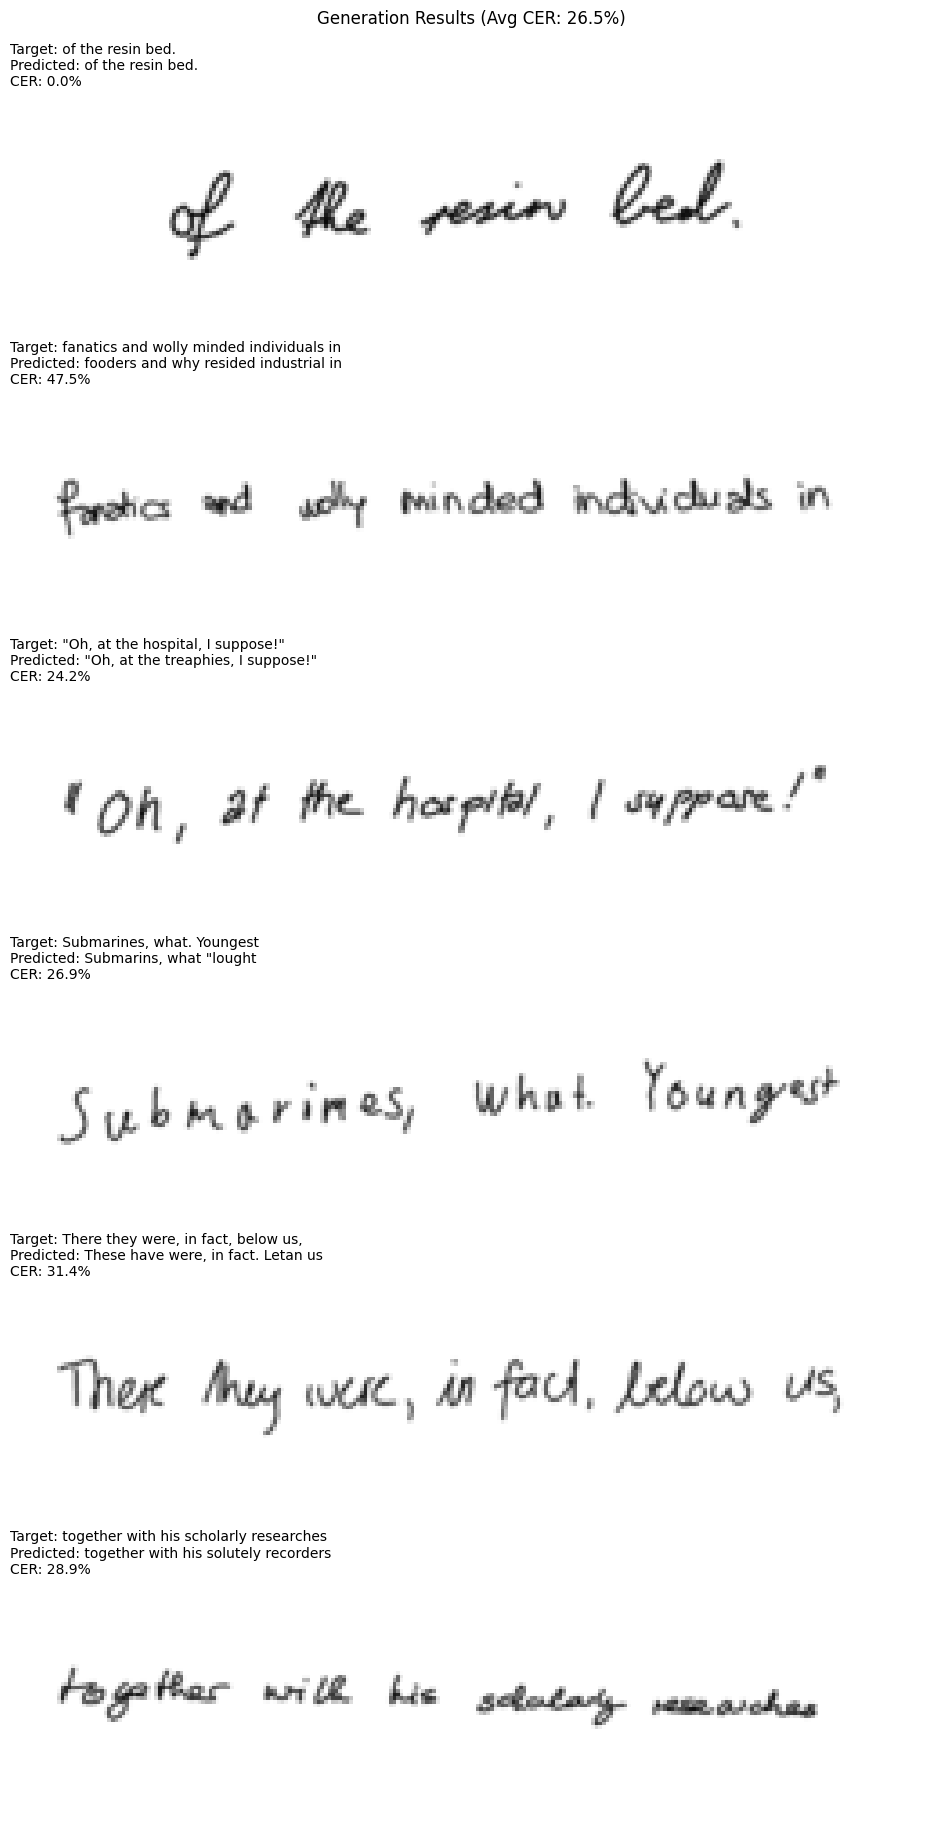

In [39]:
# Test Generation
print("Generating predictions...")

model.eval()
test_iter = iter(test_loader)
num_samples = 6

fig, axes = plt.subplots(num_samples, 1, figsize=(14, 3*num_samples))

total_cer = 0
with torch.no_grad():
    for i in range(num_samples):
        batch = next(test_iter)
        img = batch['images'].to(device)
        target = batch['texts'][0]
        
        generated = model.generate(img, max_length=64, temperature=0.0)
        pred_text = decode_tokens(
            generated[0].cpu().tolist(), idx_to_char,
            eos_id=config.eos_token_id,
            bos_id=config.bos_token_id,
            pad_id=config.pad_token_id
        )
        
        cer = compute_cer(pred_text, target)
        total_cer += cer
        
        axes[i].imshow(img[0, 0].cpu().numpy(), cmap='gray', vmin=0, vmax=1)
        title = "Target: " + target + "\nPredicted: " + pred_text + "\nCER: {:.1f}%".format(cer*100)
        axes[i].set_title(title, fontsize=10, loc='left')
        axes[i].axis('off')

plt.tight_layout()
plt.suptitle("Generation Results (Avg CER: {:.1f}%)".format(total_cer/num_samples*100), y=1.01)
plt.show()

## 6. Visualize Attention Mask

The decoder-only architecture uses a special attention mask:
- **Visual tokens**: Bidirectional attention (can see each other)
- **Text tokens**: Causal attention + can see all visual tokens


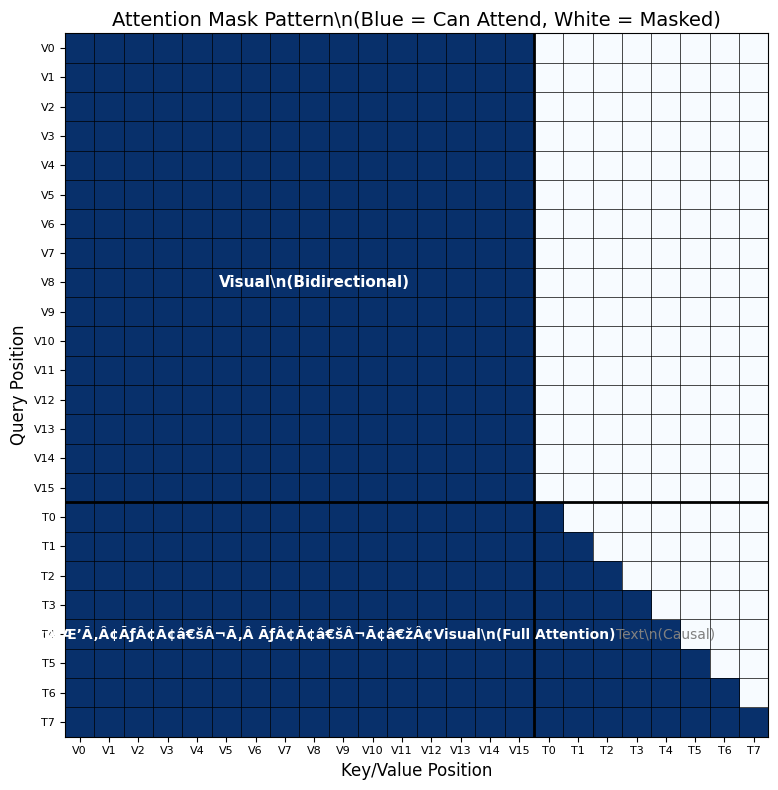

In [40]:
# Visualize attention mask pattern
n_visual = 16  # Example: 4x4 visual tokens
n_text = 8     # Example: 8 text tokens
total = n_visual + n_text

# Create attention mask
mask = torch.zeros(total, total)

# Visual tokens: bidirectional (can attend to all visual)
mask[:n_visual, :n_visual] = 1

# Text tokens: can attend to all visual tokens
mask[n_visual:, :n_visual] = 1

# Text tokens: causal attention
for i in range(n_text):
    mask[n_visual + i, n_visual:n_visual + i + 1] = 1

# Plot
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(mask.numpy(), cmap='Blues', aspect='equal')

# Add grid lines
for i in range(total + 1):
    lw = 2 if i == n_visual else 0.5
    ax.axhline(i - 0.5, color='black', linewidth=lw)
    ax.axvline(i - 0.5, color='black', linewidth=lw)

# Labels
ax.set_xticks(range(total))
ax.set_yticks(range(total))
x_labels = [f'V{i}' for i in range(n_visual)] + [f'T{i}' for i in range(n_text)]
y_labels = x_labels
ax.set_xticklabels(x_labels, fontsize=8)
ax.set_yticklabels(y_labels, fontsize=8)

ax.set_xlabel('Key/Value Position', fontsize=12)
ax.set_ylabel('Query Position', fontsize=12)
ax.set_title('Attention Mask Pattern\\n(Blue = Can Attend, White = Masked)', fontsize=14)

# Add annotations
ax.annotate('Visual\\n(Bidirectional)', xy=(n_visual/2, n_visual/2), 
            ha='center', va='center', fontsize=11, color='white', fontweight='bold')
ax.annotate('TextÃƒÆ’Ã‚Â¢ÃƒÂ¢Ã¢â€šÂ¬Ã‚Â ÃƒÂ¢Ã¢â€šÂ¬Ã¢â€žÂ¢Visual\\n(Full Attention)', xy=(n_visual/2, n_visual + n_text/2), 
            ha='center', va='center', fontsize=10, color='white', fontweight='bold')
ax.annotate('Text\\n(Causal)', xy=(n_visual + n_text/2, n_visual + n_text/2), 
            ha='center', va='center', fontsize=10, color='gray')

plt.tight_layout()
plt.show()


## 7. Final Evaluation & Save


In [41]:
# Summary
print("="*60)
print("Training Summary")
print("="*60)
print(f"Model: {results['config']['model_size']}")
print(f"Parameters: {results['config']['num_params']:,}")
print(f"Best Val CER: {results['best_cer']*100:.2f}%")
print(f"Test CER: {results['test_metrics']['cer']*100:.2f}%")
print(f"Test WER: {results['test_metrics']['wer']*100:.2f}%")
print()
print("Model saved at:", CHECKPOINT_PATH)

Training Summary
Model: small
Parameters: 9,871,414
Best Val CER: 33.63%
Test CER: 38.01%
Test WER: 38.00%

Model saved at: outputs/sota_full/best_model.pt
